In [6]:
import zipfile
import os
# Specify the path to the zip file
zip_path = '/Users/shravanir/Desktop/Manas Project /svm_train.zip'
extract_path = '/Users/shravanir/Desktop/Manas Project /'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    
# After extracting, specify the directory of the actual images
dir_train = os.path.join(extract_path, 'train')

In [7]:
# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    
# After extracting, specify the directory of the actual images
dir_train = os.path.join(extract_path, 'train')

In [9]:
import cv2
import numpy as np
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report

In [10]:

image_files = [os.path.join(dir_train, file) for file in os.listdir(dir_train) if file.endswith('.jpg')]

In [11]:
imagefiles1 = image_files[:25000]


In [12]:
def compute_hog_features(image):
    image = rgb2gray(image)  # Chuyển đổi sang ảnh xám
    features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys',
                   transform_sqrt=True)
    return features

In [13]:
# Hàm để tính toán vector đặc trưng HoG cho một hình ảnh
def compute_hog_feature(image):
    # Chuyển ảnh sang ảnh grayscale
    gray_image = rgb2gray(image)
    
    # Trích xuất đặc trưng HOG
    features, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2,2), block_norm='L2-Hys',
                              visualize=True, transform_sqrt=True)
    
    # Cân bằng độ sáng của ảnh HOG
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 20))
    
    return features, hog_image_rescaled


In [14]:
total_images = len(imagefiles1)
processed_images = 0

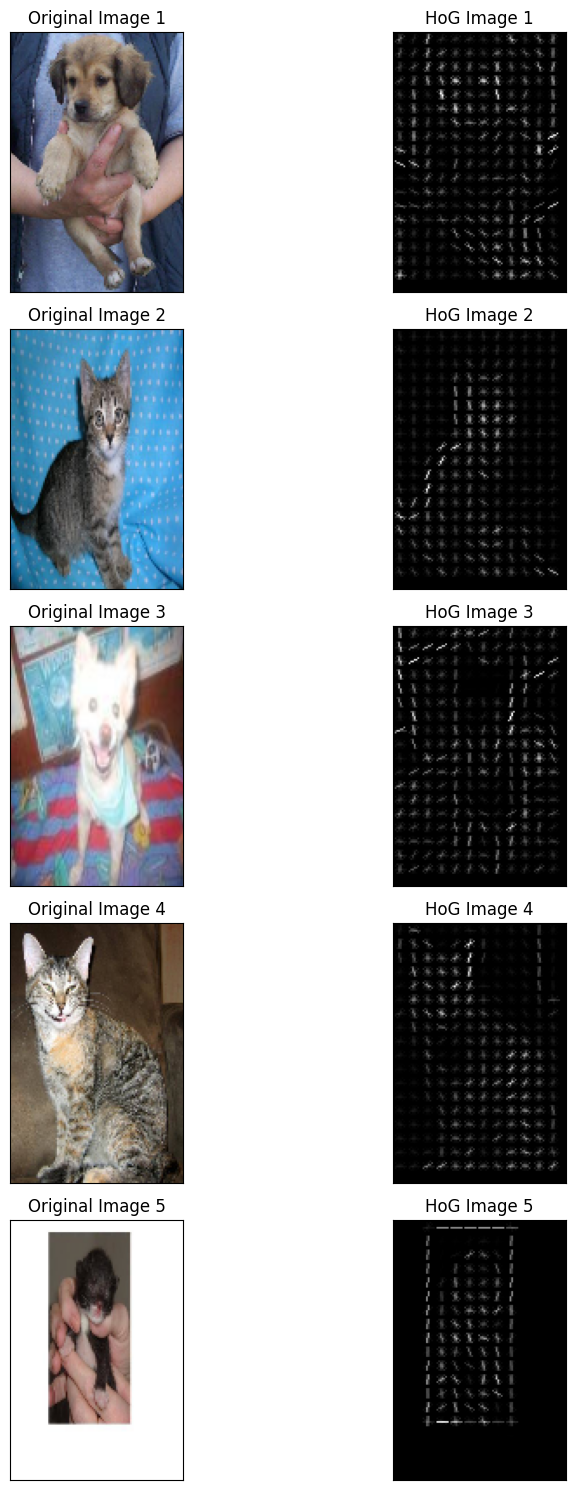

In [15]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

# Chỉ lấy 5 hình ảnh đầu tiên để hiển thị
image_files = image_files[:5]

# Tính toán vector đặc trưng HoG và lưu trữ ảnh HoG
original_images = []
hog_images = []

for image_path in image_files:
    image = cv2.imread(image_path)  # Đọc hình ảnh bằng OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Chuyển đổi sang định dạng RGB
    image = cv2.resize(image, (100,150))
    features, hog_image = compute_hog_feature(image)  # Tính toán các đặc trưng HoG
    original_images.append(image)
    hog_images.append(hog_image)

# Hiển thị ảnh gốc và ảnh HoG
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 15),
                         subplot_kw={'xticks': [], 'yticks': []})

for i in range(5):
    axes[i, 0].imshow(original_images[i])
    axes[i, 0].set_title(f'Original Image {i+1}')
    axes[i, 1].imshow(hog_images[i], cmap='gray')
    axes[i, 1].set_title(f'HoG Image {i+1}')

plt.tight_layout()
plt.show()

In [16]:
hog_features_list = []
labels = []
for image_path in imagefiles1:
    processed_images += 1
    print(f"Processing image {processed_images}/{total_images}", end="\r")
    image = cv2.imread(image_path)  # Đọc hình ảnh bằng OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Chuyển đổi sang định dạng RGB
    image = cv2.resize(image, (100,150))
    features = compute_hog_features(image)  # Tính toán các đặc trưng HoG
    hog_features_list.append(features)
    
    if 'cat' in os.path.basename(image_path):
        labels.append(0)  # 0 cho mèo
    elif 'dog' in os.path.basename(image_path):
        labels.append(1)  # 1 cho chó

In [17]:
# Chuyển đổi danh sách các vector đặc trưng và nhãn thành các mảng numpy
X = np.array(hog_features_list)
y = np.array(labels)

In [18]:
print(X.shape)
print(y.shape)


(25000, 6732)
(25000,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Sử dụng PCA để giảm chiều dữ liệu
# Chuẩn hóa tập huấn luyện
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Áp dụng PCA
pca = PCA(n_components=100)  # Bạn có thể chọn số lượng thành phần
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)

In [21]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression(max_iter=10000)
search_space = {
    'C': [0.1, 5, 10, 20]
}
GS = GridSearchCV(
    estimator=lr,  # Mô hình Logistic Regression
    param_grid=search_space,  # Không gian tìm kiếm siêu tham số
)
GS.fit(X_train_pca, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.1, 5, 10, 20]})

In [22]:
best_params = GS.best_estimator_
best_params

LogisticRegression(C=0.1, max_iter=10000)

In [23]:
lo_r = LogisticRegression(C=0.1, max_iter=10000)
lo_r.fit(X_train_pca, y_train)
y_lo_r_pred = lo_r.predict(X_test_pca)
print(classification_report(y_test, y_lo_r_pred))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71      2472
           1       0.71      0.74      0.73      2528

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000



In [24]:
svm_1 = SVC(C=1, kernel='rbf')
svm_1.fit(X_train_pca, y_train)
y_pred = svm_1.predict(X_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      2472
           1       0.78      0.79      0.78      2528

    accuracy                           0.78      5000
   macro avg       0.78      0.78      0.78      5000
weighted avg       0.78      0.78      0.78      5000



In [25]:
from sklearn.neighbors import KNeighborsClassifier
# Thiết lập K-NN và GridSearchCV để tìm kiếm tham số tốt nhất
knn = KNeighborsClassifier()

# Định nghĩa phạm vi các tham số cần tìm kiếm
param_grid = {
    'n_neighbors': [10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Sử dụng GridSearchCV để tìm kiếm tham số tốt nhất
grid_search = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_pca, y_train)

# In ra các tham số tốt nhất
print(f"Best parameters found: {grid_search.best_params_}")

# Sử dụng các tham số tốt nhất để huấn luyện và đánh giá mô hình
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_pca)

# In ra báo cáo phân loại
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.78      0.51      0.62      2472
           1       0.64      0.86      0.73      2528

    accuracy                           0.69      5000
   macro avg       0.71      0.69      0.68      5000
weighted avg       0.71      0.69      0.68      5000



In [26]:
# Thiết lập K-NN và GridSearchCV để tìm kiếm tham số tốt nhất
knn = KNeighborsClassifier()

# Định nghĩa phạm vi các tham số cần tìm kiếm
param_grid = {
    'n_neighbors': list(range(1,100)),
    'weights': ['uniform'],
    'metric': ['euclidean']
}

# Sử dụng GridSearchCV để tìm kiếm tham số tốt nhất
grid_search = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_pca, y_train)

# In ra các tham số tốt nhất
print(f"Best parameters found: {grid_search.best_params_}")

# Sử dụng các tham số tốt nhất để huấn luyện và đánh giá mô hình
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_pca)

# In ra báo cáo phân loại
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 99 candidates, totalling 495 fits
Best parameters found: {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.77      0.53      0.63      2472
           1       0.65      0.85      0.74      2528

    accuracy                           0.69      5000
   macro avg       0.71      0.69      0.68      5000
weighted avg       0.71      0.69      0.68      5000

